In [6]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [7]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

In [8]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [9]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

In [10]:
dflog=pd.read_csv("data/01_heights_weights_genders.csv")
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


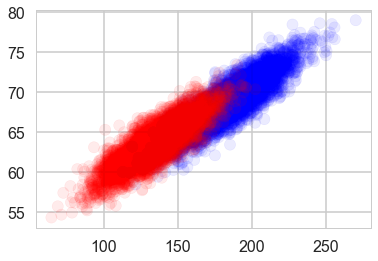

In [11]:
plt.scatter(dflog.Weight, dflog.Height, c=[cm_bright.colors[i] for i in dflog.Gender=="Male"], alpha=0.08);

In [12]:
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
from sklearn.cross_validation import train_test_split
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['Height','Weight']].values, (dflog.Gender=="Male").values)

In [15]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]
from sklearn.linear_model import LogisticRegression
max_score = 0

for C in Cs:
        clf = LogisticRegression(C=C)
        score = cv_score(clf, Xlr, ylr)

        if score > max_score:
            max_score = score
            best_C =C
print (max_score, best_C)

0.918933333333 0.1


In [16]:
clfl=LogisticRegression(C=best_C)
clfl.fit(Xlr, ylr)
ypred=clfl.predict(Xtestlr)
accuracy_score(ypred, ytestlr)

0.91959999999999997

In [17]:
from sklearn.grid_search import GridSearchCV
clfl2=LogisticRegression()
parameters = {"C": [0.0001, 0.001, 0.1, 1, 10, 100]}
fitmodel = GridSearchCV(clfl2, param_grid=parameters, cv=5, scoring="accuracy")
fitmodel.fit(Xlr, ylr)
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.grid_scores_

/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


(LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 {'C': 0.1},
 0.9192,
 [mean: 0.91787, std: 0.00758, params: {'C': 0.0001},
  mean: 0.91867, std: 0.00816, params: {'C': 0.001},
  mean: 0.91920, std: 0.00883, params: {'C': 0.1},
  mean: 0.91920, std: 0.00883, params: {'C': 1},
  mean: 0.91920, std: 0.00883, params: {'C': 10},
  mean: 0.91920, std: 0.00883, params: {'C': 100}])

In [18]:
clfl2=LogisticRegression(C=fitmodel.best_params_['C'])
clfl2.fit(Xlr, ylr)
ypred2=clfl2.predict(Xtestlr)
accuracy_score(ypred2, ytestlr)

0.91959999999999997

In [19]:
data=np.load("data/imag.pix.npy")
y=np.load("data/imag.lbl.npy")
STANDARD_SIZE = (322, 137)#standardized pixels in image.
data.shape, y.shape

((87, 132342), (87,))

In [20]:
def get_image(mat):
    size = STANDARD_SIZE[0]*STANDARD_SIZE[1]*3
    r,g,b = mat[0:size:3], mat[1:size:3],mat[2:size:3]
    rgbArray = np.zeros((STANDARD_SIZE[1],STANDARD_SIZE[0], 3), 'uint8')#3 channels
    rgbArray[..., 0] = r.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 1] = b.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 2] = g.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    return rgbArray

def display_image(mat):
    with sns.axes_style("white"):
        plt.imshow(get_image(mat))
        plt.xticks([])
        plt.yticks([])

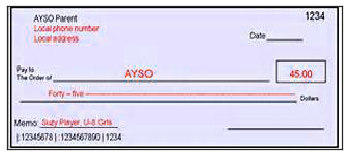

In [21]:
display_image(data[5])

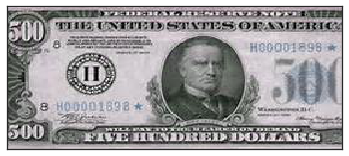

In [22]:
display_image(data[50])

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=60)
X = pca.fit_transform(data)

In [24]:
print (pca.explained_variance_ratio_.sum())

0.9424369966


The explained variance ratio `pca.explained_variance_ratio_` tells us how much of the variation in the features is explained by these 60 features. When we sum it up over the features, we see that 94% is explained: good enough to go down to a 60 dimensional space from a 136452 dimensional one!

We can see the individual varainces as we increase the dimensionality:

In [25]:
pca.explained_variance_ratio_*100

array([ 35.92596698,   6.29318801,   4.10778347,   3.11950952,
         2.81695972,   2.28831619,   2.10127948,   1.87404973,
         1.73264634,   1.53023764,   1.42159629,   1.31839333,
         1.24701509,   1.16381761,   1.09958203,   1.0607308 ,
         1.00742827,   0.98023461,   0.96055623,   0.91534723,
         0.90184539,   0.8521117 ,   0.83674252,   0.79691696,
         0.75486753,   0.72504   ,   0.70820054,   0.67966182,
         0.66083531,   0.64762577,   0.62733334,   0.5946673 ,
         0.5828891 ,   0.57441528,   0.57210293,   0.55245992,
         0.53841898,   0.53317838,   0.51646223,   0.49332326,
         0.48529457,   0.4763922 ,   0.47132419,   0.45568178,
         0.44284255,   0.43942079,   0.43308091,   0.42625203,
         0.41850578,   0.40868841,   0.40409053,   0.39031363,
         0.38800921,   0.38131284,   0.37734913,   0.36161772,
         0.3554443 ,   0.34516526,   0.33607619,   0.3331008 ])

In [26]:
df = pd.DataFrame({"y":y, "label":np.where(y==1, "check", "dollar")})
for i in range(pca.explained_variance_ratio_.shape[0]):
    df["pc%i" % (i+1)] = X[:,i]
df.head()

,y,label,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,pc51,pc52,pc53,pc54,pc55,pc56,pc57,pc58,pc59,pc60
0,1,check,-22536.362571,-2428.344022,-2133.776111,-328.317139,-1065.233631,79.735371,-425.042415,622.596554,-2490.262445,-858.658039,-1073.014454,277.322928,-1116.925639,712.871681,-787.596325,415.275221,-196.470745,472.436851,-431.694226,-607.378100,-589.816461,-270.354185,-988.101021,953.941460,1031.959995,562.960392,-37.621115,-110.195177,-519.633529,557.259812,-639.993246,78.275020,-745.890664,1238.218712,680.586124,-108.086100,511.332720,331.217630,-260.281689,96.576400,-352.480584,586.048475,546.474424,-434.564832,462.111658,-245.650995,1.283337,94.245002,-615.448868,-395.859810,-528.494823,-183.657399,433.096008,-56.489379,-107.103761,-538.769763,37.534790,-175.739577,203.826164,-124.480820
1,1,check,-22226.658685,-709.255999,-288.826100,-1300.633458,-792.067982,217.411016,1076.760348,-2115.005883,-875.590604,-1124.961604,-343.489750,-43.156843,547.549872,356.833275,-1762.430417,-370.999583,813.371984,295.882176,-942.601640,153.290522,-1123.116231,505.361627,-818.341392,716.408696,282.418173,-120.234506,820.490075,1153.227942,-351.597235,135.681269,-860.505111,605.622816,307.874744,143.857795,706.874097,-616.765589,-89.509563,-166.301712,-134.593376,-343.318225,158.268358,-142.769751,639.187991,-57.652247,248.516016,62.000689,-151.071962,396.068973,1071.263983,315.576185,-510.971213,103.772941,10.866652,297.522032,476.394382,-468.830844,-1.191794,-63.764513,30.120678,65.944614
2,1,check,-17364.260785,-4252.026796,793.804070,-1362.049569,-374.202020,3142.087962,2514.232479,1443.732695,-121.050852,-419.572090,-2083.401836,1717.909377,-723.028371,-1241.412805,-310.376368,-1059.539875,1383.805970,-798.253100,-2599.894202,-884.282604,3383.764103,-390.896646,-3413.006320,1336.140166,-4764.035867,1032.754133,2198.042907,-689.453030,1355.344291,-2142.098884,-647.438915,1683.520144,1804.698195,-3171.985440,722.819397,2276.179607,-3068.487086,3057.835242,900.194638,291.063107,1834.265993,-3878.194593,2953.990329,1375.223317,769.329415,664.550048,-779.317240,-1322.344814,-402.614481,-2730.093969,-2671.621972,1723.431553,1135.765349,-1594.325243,-1608.110031,-1968.693111,-1428.686716,-759.801287,1282.432059,-556.819737
3,1,check,-22847.256198,-900.592057,577.205124,-180.309965,-733.226392,-107.852036,1441.826054,-1069.725164,845.123872,-1389.739734,1471.004638,-725.404445,-577.309619,-254.213277,934.267865,167.767867,-298.601051,860.493193,-174.281816,1249.435406,561.799902,-164.234713,-330.002832,-360.580912,-902.311400,199.444117,1308.860727,71.169015,-270.627420,-490.287859,-122.471405,-140.485582,101.679687,856.358724,117.427645,533.560689,338.069685,257.442890,34.266480,-480.438471,1399.312085,-440.748677,-1079.742122,830.757778,712.997272,-565.564258,-670.682128,-305.830587,-777.301783,-1882.386745,-182.829020,9.984018,421.502517,-42.719332,625.053187,206.199711,127.246781,250.006829,-745.136132,-531.652675
4,1,check,-15868.672595,3259.491912,506.802761,-919.626263,2166.583606,-981.640353,-1669.712304,-391.452977,1735.628054,163.950663,-1627.263649,-556.134826,-862.530729,1721.575589,945.065310,-1133.891500,2137.769450,768.839289,-1094.488198,595.767778,-29.511256,82.990791,-504.630692,1099.877812,327.757059,-1226.573291,-709.478863,-713.439338,-157.837056,-903.027960,1010.116123,-3625.791874,2087.726526,-3417.692367,825.640643,-2136.132199,1893.400696,2156.037808,2583.162711,-398.453828,217.703536,1170.920520,1525.322740,-1501.958869,-68.959318,-773.622547,301.083005,1269.721445,2934.861005,1242.833845,-1168.849291,2193.311124,-642.715374,-422.264856,3458.148102,2719.735026,130.132542,-2273.653493,1499.440299,1780.902219


In [27]:
def normit(a):
    a=(a - a.min())/(a.max() -a.min())
    a=a*256
    return np.round(a)
def getNC(pc, j):
    size=322*137*3
    r=pc.components_[j][0:size:3]
    g=pc.components_[j][1:size:3]
    b=pc.components_[j][2:size:3]
    r=normit(r)
    g=normit(g)
    b=normit(b)
    return r,g,b
def display_component(pc, j):
    r,g,b = getNC(pc,j)
    rgbArray = np.zeros((137,322,3), 'uint8')
    rgbArray[..., 0] = r.reshape(137,322)
    rgbArray[..., 1] = g.reshape(137,322)
    rgbArray[..., 2] = b.reshape(137,322)
    plt.imshow(rgbArray)
    plt.xticks([])
    plt.yticks([])

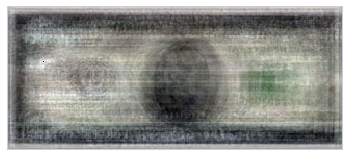

In [28]:
display_component(pca,0)

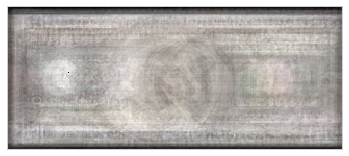

In [29]:
display_component(pca,1)

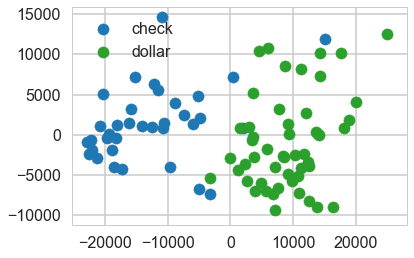

In [30]:
colors = [c0, c2]
for label, color in zip(df['label'].unique(), colors):
    mask = df['label']==label
    plt.scatter(df[mask]['pc1'], df[mask]['pc2'], c=color, label=label)
plt.legend()

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
ys=df['y'].astype(int).values
subdf=df[['pc1','pc2']]
subdfstd=(subdf - subdf.mean())/subdf.std()
Xs=subdfstd.values
def classify(X,y, nbrs, plotit=True, train_size=0.6):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf= KNeighborsClassifier(nbrs)
    clf=clf.fit(Xtrain, ytrain)
    #in sklearn accuracy can be found by using "score". It predicts and then gets the accuracy
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    Xall=np.concatenate((Xtrain, Xtest))
    if plotit:
        print ("Accuracy on training data: %0.2f" % (training_accuracy))
        print ("Accuracy on test data:     %0.2f" % (test_accuracy))
        plt.figure()
        ax=plt.gca()
        points_plot(ax, Xtrain, Xtest, ytrain, ytest, clf, alpha=0.3, psize=20)
    return nbrs, training_accuracy, test_accuracy

Accuracy on training data: 1.00
Accuracy on test data:     0.94


(1, 1.0, 0.94285714285714284)

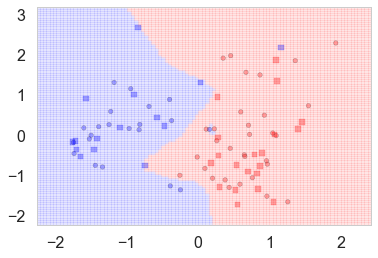

In [34]:
classify(Xs,ys,1)

Accuracy on training data: 0.62
Accuracy on test data:     0.54


(50, 0.61538461538461542, 0.54285714285714282)

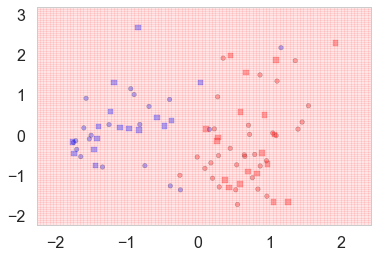

In [35]:
classify(Xs,ys,50)

In [36]:
fits={}
for k in np.arange(1,45,1):
    fits[k]=[]
    for i in range(200):
        fits[k].append(classify(Xs, ys,k, False))
nbrs=np.arange(1,45,1)
fmeanstr = np.array([1.-np.mean([t[1] for t in fits[e]]) for e in nbrs])
fmeanste = np.array([1.-np.mean([t[2] for t in fits[e]]) for e in nbrs])
fstdsstr = np.array([np.std([t[1] for t in fits[e]]) for e in nbrs])
fstdsste = np.array([np.std([t[2] for t in fits[e]]) for e in nbrs])

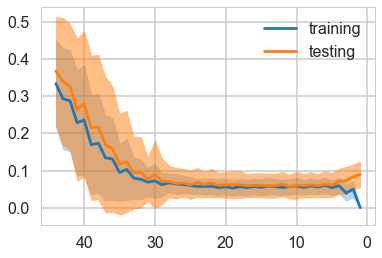

In [37]:
plt.gca().invert_xaxis()
plt.plot(nbrs, fmeanstr, color=c0, label="training");
plt.fill_between(nbrs, fmeanstr - fstdsstr, fmeanstr+fstdsstr, color=c0, alpha=0.3)
plt.plot(nbrs, fmeanste, color=c1, label="testing");
plt.fill_between(nbrs, fmeanste - fstdsste, fmeanste+fstdsste, color=c1, alpha=0.5)

plt.legend();

In [49]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print ("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [50]:
from sklearn.model_selection import train_test_split
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

In [ ]:
bestcv, Xtrain, ytrain, Xtest, ytest = do_classify(KNeighborsClassifier(), {"n_neighbors": range(1,40,2)}, df, ['pc1','pc2'], 'label', 'check' )

In [ ]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, bestcv, alpha=0.5, psize=20);

//anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
//anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


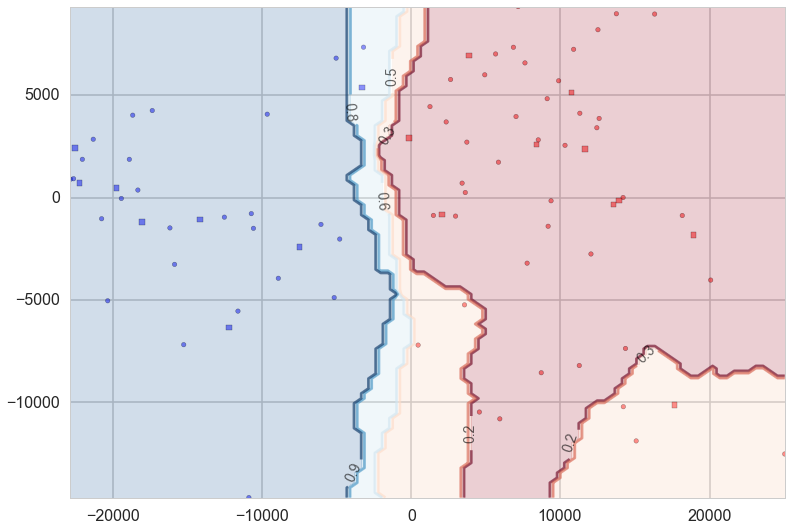

In [36]:
plt.figure()
ax=plt.gca()
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, bestcv, alpha=0.5, psize=20);

In [37]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(ytest, bestcv.predict(Xtest), )

array([[9, 1],
       [1, 7]])

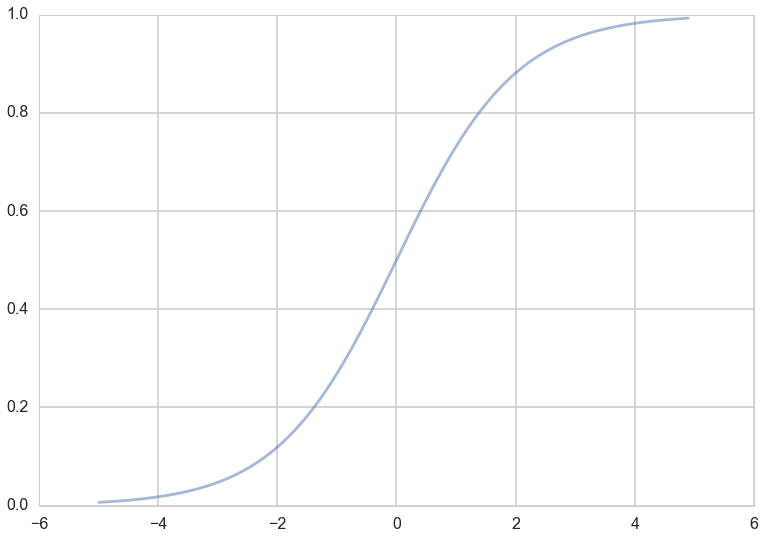

In [38]:
h = lambda z: 1./(1+np.exp(-z))
zs=np.arange(-5,5,0.1)
plt.plot(zs, h(zs), alpha=0.5);

In [39]:
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [40]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), {"C": [0.01, 0.1, 1, 10, 100]}, dflog, ['Weight', 'Height'], 'Gender','Male')

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.92
Accuracy on test data:     0.92


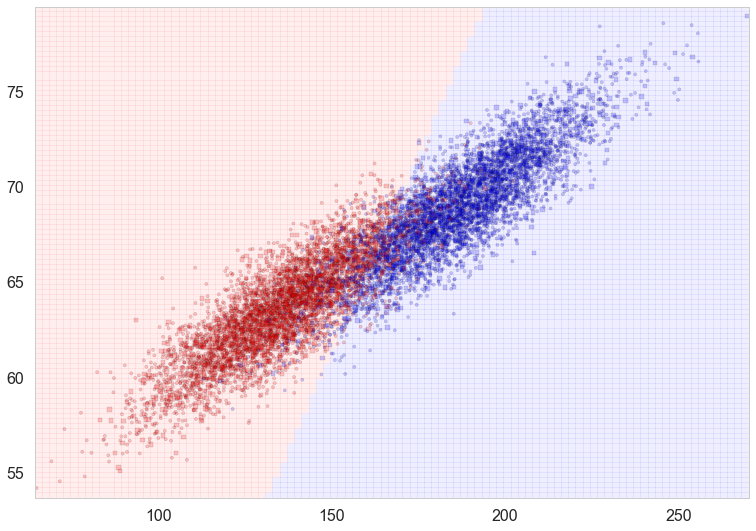

In [41]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, alpha=0.2);

In [42]:
clf_l.predict_proba(Xtest_l)

array([[  2.67350282e-01,   7.32649718e-01],
       [  9.65343424e-01,   3.46565764e-02],
       [  3.46984634e-04,   9.99653015e-01],
       ..., 
       [  9.99389269e-01,   6.10731300e-04],
       [  2.94057362e-01,   7.05942638e-01],
       [  3.75445124e-01,   6.24554876e-01]])

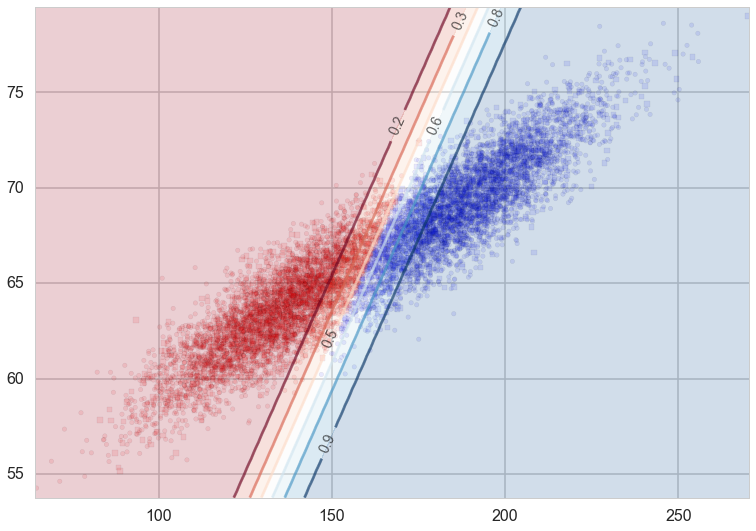

In [43]:
plt.figure()
ax=plt.gca()
points_plot_prob(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, psize=20, alpha=0.1);